# Imports

In [26]:
import math
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from sklearn.metrics import mean_squared_error

In [27]:
class PyTorchLRModel(torch.nn.Module):
    def __init__(self, in_size, out_size):
        super(PyTorchLRModel, self).__init__()

        # the Linear module applies a linear transformation to incoming data        
        self.linear = torch.nn.Linear(in_size, out_size)
        
    def forward(self, x):
        # forward performs the actual model operation

        out = self.linear(x)
        return out

In [28]:
# Trains a model
# x: features - numpy array
# y: response - numpy array
# learning_rate: learning rate for SGD
# epochs - number of epochs for SGD loop
# lambda1 - L1 regularization rate
# lambda2 - L2 regularization rate
def pytorch_lr_fit(x, y, learning_rate, epochs, lambda1, lambda2):

    # number of dimensions in incoming data
    input_dimension = x.ndim
    output_dimension = y.ndim

    # if the features are a 1-d array (a list), turn into a 2d column vector
    if input_dimension == 1:
        x = x[:, np.newaxis]
        input_size = 1
    else:
        input_size = x.shape[1]

    if output_dimension == 1:
        y = y[:, np.newaxis]
        output_size = 1
    else:
        output_size = y.shape[1]


    model = PyTorchLRModel(input_size, output_size)

    # We will use Mean Square Error as loss function
    loss_func = torch.nn.MSELoss()

    # L2 regularization is built in
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = lambda2)
    
    for epoch in range(epochs):
        features = Variable(torch.from_numpy(x).float(), requires_grad = True)
        response = Variable(torch.from_numpy(y).float())

        # the optimizer remembers gradients from the previous iteration - reset
        optimizer.zero_grad()

        predictions = model.forward(features)

        loss = loss_func(predictions, response)

        # L1 regularization needs to be done "manually"
        if lambda1 > 0.0:
            # view(-1) flattens each parameter
            # cat concatenates into a single list/array/whatever
            parameters = torch.cat([x.view(-1) for x in model.linear.parameters()])
            l1_regularization = lambda1 * torch.norm(parameters, 1)
            loss += l1_regularization

        # calculate the derivative/gradient for each feature
        loss.backward()

        # based on the gradients, take a step in the right direction
        optimizer.step()

    return model

In [29]:
scaler = MinMaxScaler()
columns = ['bmi', 'map', 'ldl', 'hdl', 'tch', 'glu', 'ltg', 'y']
feature_count = len(columns[0:-1])

print(feature_count)

7


# Import training and test data

In [30]:
training_raw = pd.read_csv('s3://helen-ml/training.csv')

training_raw.head()

,Unnamed: 0,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
1,2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0
2,3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362,206.0
3,4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641,135.0
4,10,-0.096328,-0.044642,-0.083808,0.008101,-0.103389,-0.090561,-0.013948,-0.076395,-0.062913,-0.034215,101.0


In [31]:
# fit_transform: fits the scaler to the data set, and transforms data set
training_scaled = scaler.fit_transform(training_raw[columns])

training_features = np.array(training_scaled[:, 0:feature_count])
training_response = np.array(training_scaled[:, feature_count])

print(training_features.shape)
print(training_response.shape)

(283, 7)
(283,)


In [32]:
# testing data
test_raw = pd.read_csv('s3://helen-ml/test.csv')

test_raw.head()

,Unnamed: 0,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,43,0.019913,-0.044642,-0.023451,-0.071085,0.020446,-0.010082,0.118591,-0.076395,-0.042572,0.073480,92.0
1,380,0.016281,-0.044642,0.026128,0.058596,-0.060735,-0.044215,-0.013948,-0.033958,-0.051401,-0.025930,52.0
2,260,0.041708,-0.044642,-0.008362,-0.057314,0.008063,-0.031376,0.151726,-0.076395,-0.080237,-0.017646,39.0
3,336,-0.020045,-0.044642,0.085408,-0.036656,0.091996,0.089499,-0.061809,0.145012,0.080948,0.052770,306.0
4,326,0.045341,0.050680,-0.008362,-0.033214,-0.007073,0.001191,-0.039719,0.034309,0.029936,0.027917,131.0


In [33]:
# transform: reuses already-fitted scaler, so that test data is scaled
# using the same scale as the training data, for apples-to-apples comparison
test_scaled = scaler.transform(test_raw[columns])
test_features = test_scaled[:, 0:feature_count]
test_response = test_scaled[:, feature_count]

print(test_features.shape)
print(test_response.shape)

(88, 7)
(88,)


In [44]:
training_input = Variable(torch.from_numpy(training_features).float())
test_input = Variable(torch.from_numpy(test_features).float())

# Train and evaluate model

In [45]:
# train model
model = pytorch_lr_fit(training_features, training_response, 0.1, 1000, 0.001, 0.001)    

# predictions
predictions_training = model(training_input)
predictions_test = model(test_input)

print(predictions_training.shape)
print(predictions_test.shape)

torch.Size([283, 1])
torch.Size([88, 1])


In [46]:
rmse_training = math.sqrt(mean_squared_error(predictions_training.data.numpy(), training_response))

print(rmse_training)

rmse_test = math.sqrt(mean_squared_error(predictions_test.data.numpy(), test_response))

print(rmse_test)

0.17547955527131026
0.17921490816866706


In [47]:
plot_x = list(range(10, 1000, 10))
plot_y = list()

for e in plot_x:
    m = pytorch_lr_fit(training_features, training_response, 0.1, e, 0, 0)
    p = m(test_input)
    r = math.sqrt(mean_squared_error(p.data.numpy(), test_response))
    plot_y.append(r)

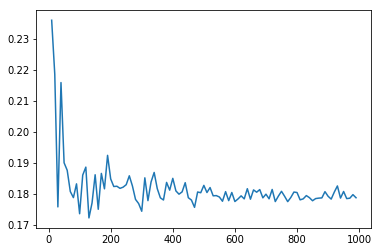

In [38]:
plt.plot(plot_x, plot_y)
plt.show()

In [53]:
plot_x = list()
plot_y1 = list()
plot_y2 = list()

for i in list(range(0, 100, 1)):
    l2 = i/1000 # 0 to 0.1 in steps of 0.001
    model = pytorch_lr_fit(training_features, training_response, 0.1, 400, 0, l2)
    pred_test = model(test_input)
    pred_training = model(training_input)
    rmse_test = math.sqrt(mean_squared_error(pred_test.data.numpy(), test_response))
    rmse_training = math.sqrt(mean_squared_error(pred_training.data.numpy(), training_response))
    plot_x.append(l2)
    plot_y1.append(rmse_test)
    plot_y2.append(rmse_training)

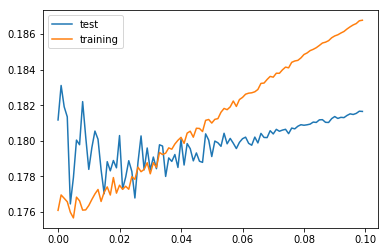

In [56]:
plt.plot(plot_x2, plot_y1, label='test')
plt.plot(plot_x2, plot_y2, label='training')
plt.legend()
plt.show()